In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs
!ls german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.
signnames.csv  test.p  train.p	valid.p


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import pandas as pd
import cv2

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
  test_data = pickle.load(f)

In [ ]:
# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


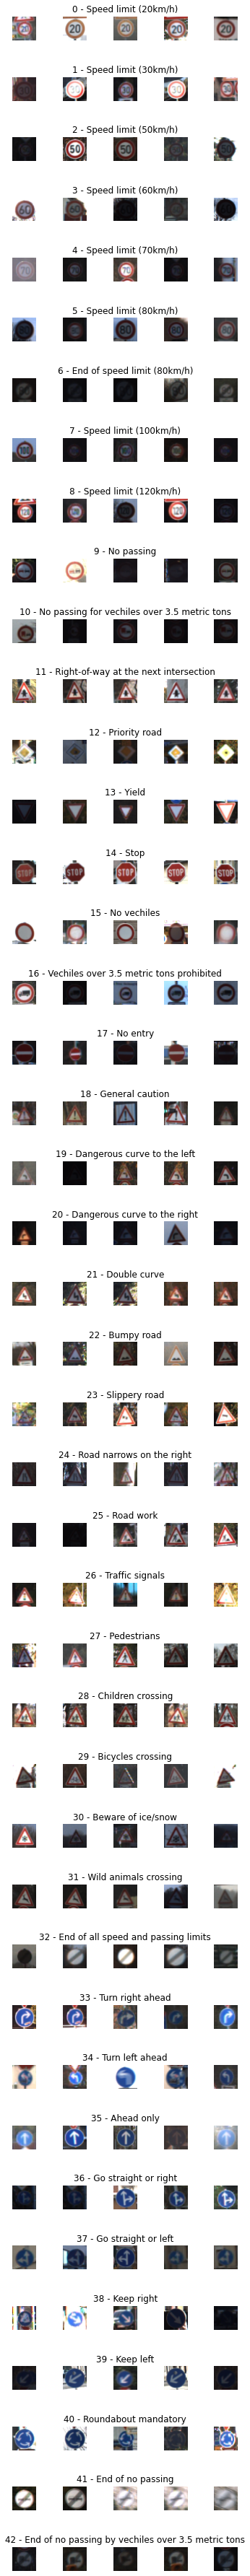

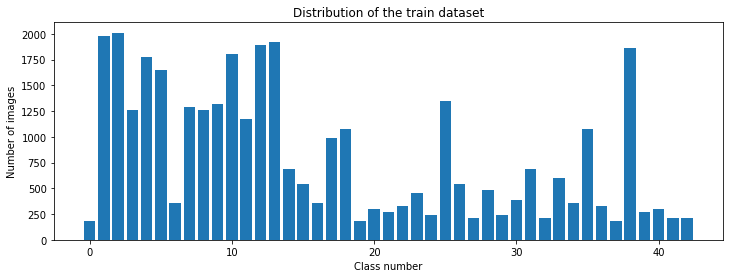

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples=[]
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap='gray')
        axs[j][i].axis("off")
        if i == 2:
          axs[j][i].set_title(str(j) + " - " + row["SignName"])
          num_of_samples.append(len(x_selected))

print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36
(32, 32)
(32, 32)


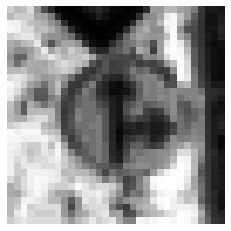

In [ ]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

def grayscale(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_img = 255 - gray_img
    return gray_img

img = grayscale(X_train[1000])
plt.imshow(img,cmap='gray')
plt.axis("off")
print(img.shape)

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img,cmap='gray')
plt.axis("off")
print(img.shape)

(34799, 32, 32)


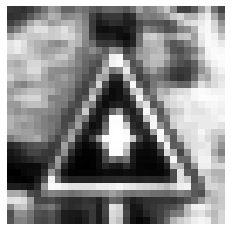

In [ ]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

plt.imshow(X_train[random.randint(0, len(X_train) - 1)],cmap='gray')
plt.axis('off')
print(X_train.shape)
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

(20, 32, 32, 1)


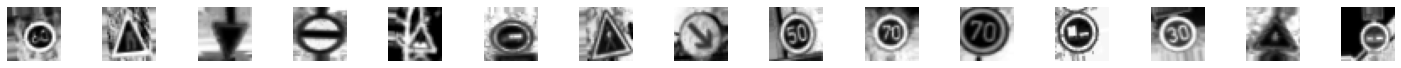

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1,\
                             height_shift_range=0.1,\
                             zoom_range=0.2,\
                             shear_range=0.1,\
                             rotation_range=10.)

datagen.fit(X_train)

batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32),cmap='gray')
    axs[i].axis("off")

print(X_batch.shape)
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [ ]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(learning_rate= 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model = modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=50),\
                            steps_per_epoch = len(X_train)//50,\
                            epochs=10,\
                            batch_size=50,\
                            validation_data=(X_val, y_val),\
                            validation_steps=len(X_val)//50,\
                            shuffle = True)  


Epoch 1/10
 89/695 [==>...........................] - ETA: 6:28 - loss: 3.4253 - accuracy: 0.1031

KeyboardInterrupt: ignored

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])


In [ ]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap='gray')

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = 'gray')
print(img.shape)
img = img.reshape(1, 32, 32, 1)

print("predicted sign: "+ str(np.argmax(model.predict(img))))